In [ ]:
pip install g2p-en

In [ ]:
import torch
import torch.nn as nn
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from g2p_en import G2p
g2p = G2p()

In [ ]:
import pandas as pd
import ast

unique_phenomes = set()
df = pd.read_csv("data.csv")

for index, row in df.iterrows():
  phonemes = ast.literal_eval(row["phoneme1"])
  for p in phonemes:
    unique_phenomes.add(p)

In [ ]:
unique_phenomes = sorted(list(unique_phenomes))
print(unique_phenomes)
print(len(unique_phenomes))
phoneme_to_index = {phoneme: index for index, phoneme in enumerate(unique_phenomes)}
print(phoneme_to_index)

['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0', 'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH0', 'UH1', 'UH2', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH']
69
{'AA0': 0, 'AA1': 1, 'AA2': 2, 'AE0': 3, 'AE1': 4, 'AE2': 5, 'AH0': 6, 'AH1': 7, 'AH2': 8, 'AO0': 9, 'AO1': 10, 'AO2': 11, 'AW0': 12, 'AW1': 13, 'AW2': 14, 'AY0': 15, 'AY1': 16, 'AY2': 17, 'B': 18, 'CH': 19, 'D': 20, 'DH': 21, 'EH0': 22, 'EH1': 23, 'EH2': 24, 'ER0': 25, 'ER1': 26, 'ER2': 27, 'EY0': 28, 'EY1': 29, 'EY2': 30, 'F': 31, 'G': 32, 'HH': 33, 'IH0': 34, 'IH1': 35, 'IH2': 36, 'IY0': 37, 'IY1': 38, 'IY2': 39, 'JH': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'NG': 45, 'OW0': 46, 'OW1': 47, 'OW2': 48, 'OY0': 49, 'OY1': 50, 'OY2': 51, 'P': 52, 'R

In [ ]:
def one_hot_encode(word, conversion):
  one_hot = []
  for phoneme in word:
    curr = np.zeros(69)
    curr[conversion[phoneme]] = 1
    one_hot.append(curr)
  return np.array(one_hot)


In [ ]:
df_encoded = pd.DataFrame(columns = ['Word1', 'Word2', 'Similarity'])
one_hot_words = []
for index, row in df.iterrows():
  word1_encoded = one_hot_encode(ast.literal_eval(row["phoneme1"]), phoneme_to_index)
  word2_encoded = one_hot_encode(ast.literal_eval(row["phoneme2"]), phoneme_to_index)
  similarity = row["similar"]
  one_hot_words.append((word1_encoded, word2_encoded, similarity))


In [ ]:
from sklearn.model_selection import train_test_split

X = np.array([(pair[0], pair[1]) for pair in one_hot_words])
y = np.array([pair[2] for pair in one_hot_words])

<ipython-input-68-066d0fd670b2>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([(pair[0], pair[1]) for pair in one_hot_words])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

class_counts = np.bincount(y_train)
class_weights = 1. /class_counts
class_weights /= class_weights.sum()
class_weights = torch.FloatTensor(class_weights).to(device)
print(class_weights)

tensor([0.0222, 0.9778], device='cuda:0')


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        return out

In [ ]:
class SiameseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SiameseLSTM, self).__init__()
        self.lstm = LSTMModel(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x1, x2):
        out1 = self.lstm(x1)
        out2 = self.lstm(x2)
        out = torch.abs(out1 - out2)
        out = self.fc(out)
        return out

In [ ]:


from torch.utils.data import Dataset, DataLoader

class SiameseDataset(Dataset):
    def __init__(self, word_pairs, labels):
        self.word_pairs = word_pairs
        self.labels = labels

    def __len__(self):
        return len(self.word_pairs)

    def __getitem__(self, idx):
        word_pair = self.word_pairs[idx]
        word1 = torch.Tensor(word_pair[0])
        word2 = torch.Tensor(word_pair[1])
        label = torch.LongTensor([self.labels[idx]])
        return word1, word2, label

In [ ]:
from torch.nn.utils.rnn import pad_sequence

batch_size = 128
train_dataset = SiameseDataset(X_train, y_train)

def collate_fn(batch):
    word1s, word2s, labels = zip(*batch)
    word1s_padded = pad_sequence(word1s, batch_first=True, padding_value=0)
    word2s_padded = pad_sequence(word2s, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return word1s_padded, word2s_padded, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataset = SiameseDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataset = SiameseDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [ ]:
input_size = 69
hidden_size = 150
num_layers = 4

model = SiameseLSTM(input_size, hidden_size, num_layers)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)
print(class_weights.shape, class_weights)


torch.Size([2]) tensor([0.0222, 0.9778], device='cuda:0')


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
num_epochs = 30
# Create lists to save the losses
train_losses = []
valid_losses = []
validation_cutoff = np.inf
save_model = model

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for i, (word1, word2, labels) in enumerate(train_loader):
        word1 = word1.to(device)
        word2 = word2.to(device)
        labels = labels.squeeze().to(device)
        #print("labels",labels.shape)

        outputs = model(word1, word2)
        #print("outputs",outputs.shape)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * word1.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    all_labels = []
    all_predictions = []
    valid_loss = 0.0
    with torch.no_grad():
        for i, (word1, word2, labels) in enumerate(val_loader):
            word1 = word1.to(device)
            word2 = word2.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(word1, word2)
            _,predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            loss = criterion(outputs, labels)

            valid_loss += loss.item() * word1.size(0)

    valid_loss = valid_loss / len(val_loader.dataset)
    valid_losses.append(valid_loss)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')


    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1_score:.2f}')

    if valid_loss < validation_cutoff:
      save_model = model

Epoch 1/30, Train Loss: 0.5153, Valid Loss: 0.4320
Precision: 0.10, Recall: 0.90, F1-score: 0.18
Epoch 2/30, Train Loss: 0.3141, Valid Loss: 0.2685
Precision: 0.18, Recall: 0.96, F1-score: 0.30
Epoch 3/30, Train Loss: 0.2223, Valid Loss: 0.1915
Precision: 0.20, Recall: 0.99, F1-score: 0.33
Epoch 4/30, Train Loss: 0.1528, Valid Loss: 0.1204
Precision: 0.38, Recall: 0.99, F1-score: 0.54
Epoch 5/30, Train Loss: 0.1066, Valid Loss: 0.0903
Precision: 0.46, Recall: 0.99, F1-score: 0.63
Epoch 6/30, Train Loss: 0.0879, Valid Loss: 0.0995
Precision: 0.44, Recall: 0.98, F1-score: 0.61
Epoch 7/30, Train Loss: 0.0742, Valid Loss: 0.0586
Precision: 0.58, Recall: 0.99, F1-score: 0.74
Epoch 8/30, Train Loss: 0.0500, Valid Loss: 0.0554
Precision: 0.68, Recall: 1.00, F1-score: 0.81
Epoch 9/30, Train Loss: 0.0396, Valid Loss: 0.0636
Precision: 0.52, Recall: 0.98, F1-score: 0.68
Epoch 10/30, Train Loss: 0.0378, Valid Loss: 0.0467
Precision: 0.72, Recall: 0.99, F1-score: 0.83
Epoch 11/30, Train Loss: 0.02

In [ ]:
model = save_model
torch.save(model, 'checkpoint.pth')

In [ ]:
model = torch.load('checkpoint.pth')
model.eval()

SiameseLSTM(
  (lstm): LSTMModel(
    (lstm): LSTM(69, 150, num_layers=4, batch_first=True)
  )
  (fc): Linear(in_features=150, out_features=2, bias=True)
)

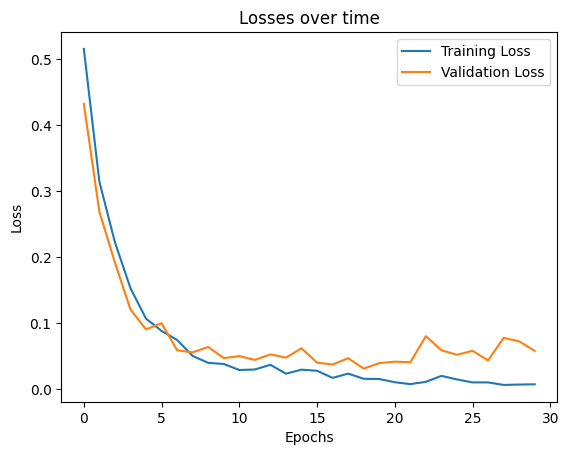

In [ ]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Losses over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (word1, word2, labels) in enumerate(data_loader):
            word1 = word1.to(device)
            word2 = word2.to(device)
            labels = labels.to(device)
            #print(labels.reshape(1,labels.size(0)))
            outputs = model(word1, word2)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
            # Debugging print statements:
            #print("Labels:", labels)
            #print("Predicted:", predicted)
            #print("Total so far:", total)
            #print("Correct so far:", correct)
    return correct / total

accuracy = evaluate(model, test_loader, device)
print('Accuracy on test data:', accuracy)

Accuracy on test data: 0.9958832335329342


In [ ]:
def compare_words(model, word1, word2, real_word1, real_word2):
    model.eval()
    with torch.no_grad():
        word1_encoded = torch.tensor([one_hot_encode(word1, phoneme_to_index)], dtype=torch.float32).to(device)
        word2_encoded = torch.tensor([one_hot_encode(word2, phoneme_to_index)], dtype=torch.float32).to(device)
        output = model(word1_encoded, word2_encoded)
        _, predicted = torch.max(output.data, 1)
        if predicted.item() == 1:
            print(f"'{real_word1}' and '{real_word2}' are phonetically similar.")
        else:
            print(f"'{real_word1}' and '{real_word2}' are not phonetically similar.")

In [ ]:

word_1 = "elastic"
word_2 = "electric"
word1 = g2p(word_1)
word2 = g2p(word_2)
print(word1)
print(word2)
import time

['IH0', 'L', 'AE1', 'S', 'T', 'IH0', 'K']
['IH0', 'L', 'EH1', 'K', 'T', 'R', 'IH0', 'K']


In [ ]:
start_time = time.time()
compare_words(model, word1, word2,word_1,word_2)
print("--- %s seconds ---" % (time.time() - start_time))


'elastic' and 'electric' are phonetically similar.
--- 0.004469871520996094 seconds ---


In [ ]:
words =["ability", "absence", "academy", "activity", "advantage", "adventure", "afternoon", "agreement",
"alternative", "announcement", "apartment", "application", "architecture", "assignment", "assistance",
"atmosphere", "attention", "awareness", "background", "basketball", "billionaire", "biography",
"boundary", "breakfast", "brilliant", "broadcast", "brotherhood", "calculator", "celebration",
"characteristic", "chemistry", "chocolate", "civilization", "collection", "communication", "comparison",
"competition", "commuter", "compromise", "concentration", "conclusion", "confidence", "connection",
"consequence", "consideration", "consultation", "contribution", "cooperation", "coordination",
"corporation", "declaration", "definition", "democracy", "depression", "description", "determination",
"development", "difference", "difficulty", "discussion", "distribution", "diversity", "education",
"efficiency", "engineering", "environment", "evaluation", "examination", "expectation", "experience",
"explanation", "expression", "fascination", "foundation", "friendship", "government", "graduation",
"happiness", "heritage", "hospitality", "imagination", "impression", "improvement", "independence",
"information", "inspiration", "instruction", "intelligence", "interpretation", "introduction",
"investigation", "leadership", "literature", "mathematics", "measurement", "membership", "motivation",
"negotiation", "observation", "opportunity", "organization", "participation", "performance", "philosophy",
"photography", "possession", "preparation", "presentation", "preservation", "probability", "production",
"progression", "projection", "promotion", "proposition", "psychology", "qualification", "realization",
"recognition", "recommendation", "recreation", "reflection", "reformation", "relationship", "representation",
"reputation", "reservation", "resistance", "resolution", "restaurant", "revelation", "revolution",
"satisfaction", "scholarship", "significance", "specification", "speculation", "statistics", "stimulation",
"strengthen", "structure", "submission", "substitution", "succession", "suggestion", "superintendent",
"supervision", "technology", "temperature", "transportation", "understanding", "university", "visualization"]
word_list = [g2p(x) for x in words]
from collections import defaultdict

word_dict = defaultdict(list)
for word in words:
    word_dict[tuple(g2p(word))].append(word)
print(word_dict)

defaultdict(<class 'list'>, {('AH0', 'B', 'IH1', 'L', 'AH0', 'T', 'IY0'): ['ability'], ('AE1', 'B', 'S', 'AH0', 'N', 'S'): ['absence'], ('AH0', 'K', 'AE1', 'D', 'AH0', 'M', 'IY0'): ['academy'], ('AE0', 'K', 'T', 'IH1', 'V', 'AH0', 'T', 'IY0'): ['activity'], ('AE0', 'D', 'V', 'AE1', 'N', 'T', 'IH0', 'JH'): ['advantage'], ('AE0', 'D', 'V', 'EH1', 'N', 'CH', 'ER0'): ['adventure'], ('AE2', 'F', 'T', 'ER0', 'N', 'UW1', 'N'): ['afternoon'], ('AH0', 'G', 'R', 'IY1', 'M', 'AH0', 'N', 'T'): ['agreement'], ('AO0', 'L', 'T', 'ER1', 'N', 'AH0', 'T', 'IH0', 'V'): ['alternative'], ('AH0', 'N', 'AW1', 'N', 'S', 'M', 'AH0', 'N', 'T'): ['announcement'], ('AH0', 'P', 'AA1', 'R', 'T', 'M', 'AH0', 'N', 'T'): ['apartment'], ('AE2', 'P', 'L', 'AH0', 'K', 'EY1', 'SH', 'AH0', 'N'): ['application'], ('AA1', 'R', 'K', 'AH0', 'T', 'EH2', 'K', 'CH', 'ER0'): ['architecture'], ('AH0', 'S', 'AY1', 'N', 'M', 'AH0', 'N', 'T'): ['assignment'], ('AH0', 'S', 'IH1', 'S', 'T', 'AH0', 'N', 'S'): ['assistance'], ('AE1', 'T',

In [ ]:
import torch.nn.functional as F
def batch_eval(model, word1, word_list):
  similar_words = []
  similar_real_words = []
  batch_size = 128
  word1_encoded = one_hot_encode(word1, phoneme_to_index)
  word1_encoded_batch = torch.stack([torch.tensor(word1_encoded, dtype=torch.float32).to(device)] * len(word_list))
  word2_encoded_list = [one_hot_encode(word2, phoneme_to_index) for word2 in word_list]
  max_length = max(len(word) for word in word2_encoded_list)
  word2_encoded_batch = torch.stack([F.pad(torch.tensor(word2_encoded, dtype=torch.float32), (0, 0, 0, max_length - len(word2_encoded))).to(device) for word2_encoded in word2_encoded_list])

  for i in range(0, len(word_list), batch_size):
    batch_word1 = word1_encoded_batch[i:i+batch_size]
    batch_word2 = word2_encoded_batch[i:i+batch_size]
    with torch.no_grad():
      output = model(batch_word1, batch_word2)
      _, predicted = torch.max(output.data, 1)
      similar_indices = (predicted == 1).nonzero(as_tuple=True)[0]
      similar_words.extend([word_list[i + index.item()] for index in similar_indices])
  for word in similar_words:
    similar_real_words.append(word_dict[tuple(word)])
  print(f"'{word_1}' is phonetically similar to the following words: {similar_real_words}")

start_time = time.time()
batch_eval(model, word1, word_list)
print("--- %s seconds ---" % (time.time() - start_time))


'lot' is phonetically similar to the following words: []
--- 0.017380714416503906 seconds ---
